# Homework 2: Stochastic Gradient Descent

```{warning}
The submission of the homeworks has **NO** deadline. You can submit them whenever you want, on Virtuale. You are only required to upload it on Virtuale **BEFORE** your exam session, since the Homeworks will be a central part of the oral exam. 

You are asked to submit the homework as one of the two, following modalities:
* A PDF (or Word) document, containing screenshoots of code snippets, screeshots of the results generated by your code, and a brief comment on the obtained results.
* A Python Notebook (i.e. a `.ipynb` file), with cells containing the code required to solve the indicated exercises, alternated with a brief comment on the obtained results in the form of a markdown cell. We remark that the code **SHOULD NOT** be runned during the exam, but the student is asked to enter the exam with all the programs **already executed**, with the results clearly visible on the screen.

Joining the oral exam with a non-executed code OR without a PDF file with the obtained results visible on that, will cause the student to be rejected.
```


## Exercise 1: SGD vs GD on a Simple 1D Regression Problem

Consider the synthetic dataset

$$
x^{(i)} = \frac{i}{N},\qquad
y^{(i)} = 2x^{(i)} + 1 + \varepsilon^{(i)}, \qquad \varepsilon^{(i)}\sim\mathcal N(0,0.01),
$$

with $N = 200$.
We model the data with a linear function:

$$
f_\Theta(x) = \Theta_0 + \Theta_1 x = \Theta^T \tilde{x},
$$

if we define $\tilde{x} = [1, x]$ as we did during the lab session.


1. Implement the MSE loss:
   
   $$
   \mathcal L(\Theta)=\frac{1}{N}\sum_{i=1}^N (f_\Theta(x^{(i)}) - y^{(i)})^2.
   $$


In [22]:
import numpy as np
import matplotlib.pyplot as plt

N = 200
X = np.linspace(0, 1, N)
Y = 2 * X + np.random.normal(0, 0.1, size=N)

def f(theta, X):
    return theta[0] + theta[1] * X

def l(theta, X, Y):
    r = f(theta, X) - Y
    return np.mean(r**2)

def grad_l(theta, X, Y):
    r = f(theta, X) - Y
    g0 = 2 * np.mean(r)
    g1 = 2 * np.mean(r * X)
    return np.array([g0, g1])



2. Implement **full GD** and **SGD** (mini-batch) using batch sizes:
   - $N_{\text{batch}} = 1$,
   - $N_{\text{batch}} = 10$,
   - $N_{\text{batch}} = 50$,
   - $N_{\text{batch}} = N$ (this recovers GD).


In [23]:
def GD(l, grad_l, X, Y, theta_0, eta, maxit):
    theta_vals = [theta_0]
    for k in range(maxit):
        theta = theta_0 - eta * grad_l(theta_0, X, Y)
        theta_0 = theta
        theta_vals.append(theta)
    return theta_0, np.array(theta_vals)


def SGD(l, grad_l, X, Y, Theta0, lr=1e-2, batch_size=32, epochs=10):
    
    Theta = Theta0.copy()

    Theta_hist = [Theta0].copy()
    loss_hist = [l(Theta, X, Y)]

    for epoch in range(epochs):
        shuffle_idx = np.arange(len(X))
        np.random.shuffle(shuffle_idx)

        Xs = X[shuffle_idx]
        Ys = Y[shuffle_idx]

        n_batches = len(Xs) // batch_size
        for batch in range(n_batches):

            Xb = Xs[batch * batch_size : (batch+1) * batch_size]
            Yb = Ys[batch * batch_size : (batch+1) * batch_size]

            g = grad_l(Theta, Xb, Yb)
            Theta = Theta - lr * g

            Theta_hist.append(Theta.copy())

        loss_hist.append(l(Theta, X, Y))
    return Theta, np.array(Theta_hist), np.array(loss_hist)



3. Plot for each method:
   - the loss curve (loss vs epoch),
   - the trajectory of parameters $(\Theta_0,\Theta_1)$ in the 2D parameter space. This is similar to what you did in the previous homework: simply plot the value of $\Theta_0^{(k)}$ and $\Theta_1^{(k)}$ for all the $k$s in a 2-dimensional plot.


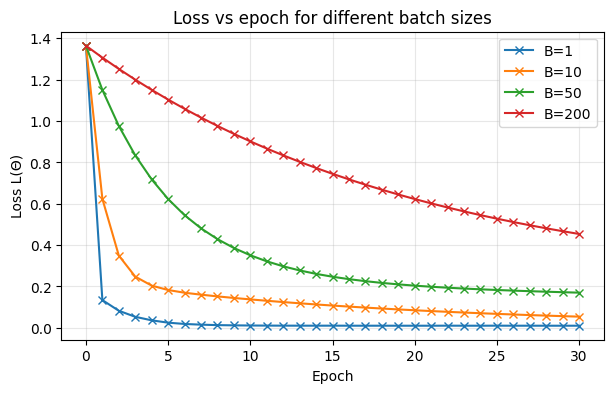

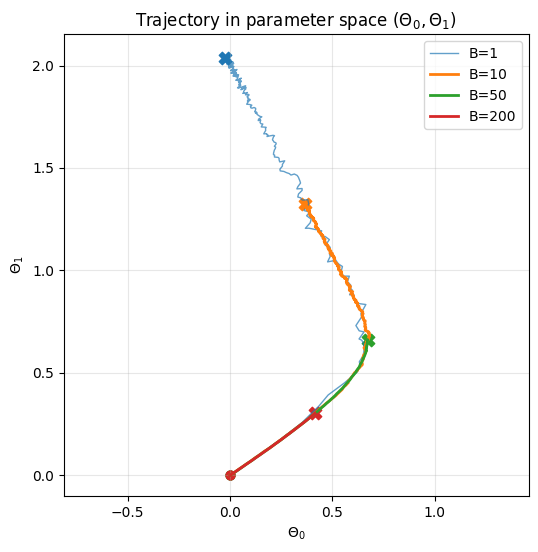

In [24]:
theta0 = np.array([0.0, 0.0])
epochs = 30
lr = 1e-2
batch_sizes = [1, 10, 50, 200]

results = {}

for B in batch_sizes:
    Theta_final, Theta_hist, loss_hist = SGD(l, grad_l, X, Y, theta0, lr=lr, batch_size=B, epochs=epochs)
    results[B] = {"Theta_hist": Theta_hist, "loss_hist": loss_hist, "Theta_final": Theta_final}


plt.figure(figsize=(7,4))
for B in batch_sizes:
    plt.plot(results[B]["loss_hist"], marker="x", label=f"B={B}")
#plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss L(Θ)")
plt.grid(alpha=0.3)
plt.title("Loss vs epoch for different batch sizes")
plt.legend()
plt.show()

plt.figure(figsize=(6,6))

for B in batch_sizes:
    th = results[B]["Theta_hist"]

    #  most noisy traj
    if B == 1:
        th_plot = th[::10]   # keep every 10th point
        lw = 1.0
        alpha = 0.7
    else:
        th_plot = th
        lw = 2.0
        alpha = 1.0

    plt.plot(
        th_plot[:,0],
        th_plot[:,1],
        linewidth=lw,
        alpha=alpha,
        label=f"B={B}"
    )

    # Start o
    plt.scatter(
        th_plot[0,0],
        th_plot[0,1],
        s=40,
        marker="o",
        color=plt.gca().lines[-1].get_color()
    )

    # End x
    plt.scatter(
        th_plot[-1,0],
        th_plot[-1,1],
        s=80,
        marker="X",
        color=plt.gca().lines[-1].get_color()
    )

plt.xlabel(r"$\Theta_0$")
plt.ylabel(r"$\Theta_1$")
plt.title(r"Trajectory in parameter space $(\Theta_0,\Theta_1)$")
plt.grid(alpha=0.3)
plt.legend()
plt.axis("equal") 
plt.show()




4. Discuss:
   - Why GD is smooth but slow for large $N$,
   - Why SGD is noisy but progresses faster,
   - How batch size affects the noise level and convergence stability.

## Exercise 2: Variance of the Stochastic Gradient (1D Experiment)

Fix a parameter vector $\Theta$, and repeatedly draw random mini-batches of the same size.

1. Choose batch sizes:
   
   $$
   N_{\text{batch}} \in \{1, 5, 20, N\}.
   $$


In [25]:
batch_sizes = [1, 5, 20, N]

2. At the **same** $\Theta$, compute:
   
   $$
   g_k = \nabla_\Theta \mathcal L(\Theta; \mathcal M_k)
   $$

   for 100 randomly sampled batches $\mathcal M_k$.


In [ ]:
theta_fixed = np.array([0.0, 0.0])

def grad_samples_shuff(grad_l, X, Y, Theta_fixed, batch_size, K = 100, seed=0):
    rng = np.random.default_rng(seed)

    G = []

    while len(G) < K:
        shuffle_idx = np.arange(len(X))
        rng.shuffle(shuffle_idx)

        Xs = X[shuffle_idx]
        Ys = Y[shuffle_idx]

        n_batches = int(np.ceil(len(Xs) / batch_size))

        for b in range(n_batches):
            if len(G) >= K:
                break
                
            start = b * batch_size
            end = min((b+1)*batch_size, len(Xs))

            Xb = Xs[start:end]
            Yb = Ys[start:end]

            if (end - start) < batch_size:
                continue

            gk = grad_l(Theta_fixed, Xb, Yb)
            G.append(gk)
    
    return np.array(G)

grads_by_batch = {}

for b in batch_sizes:
    grads_by_batch[b] = grad_samples_shuff(grad_l, X, Y, theta_fixed, batch_size=b, K = 100, seed=42)


3. For each batch size, compute the empirical variance:
   
   $$
   \mathrm{Var}(g) = \frac{1}{100}\sum_{k=1}^{100} \|g_k - \bar g\|^2,
   $$

   where $\bar{g}$ is the average of the $g_k$ 's, defined as:

   $$
   \bar{g} = \frac{1}{100} \sum_{k=1}^{100} g_k.
   $$

In [29]:
def empirical_variance(G):
    gbar = G.mean(axis = 0)
    diffs = G - gbar
    var = np.mean(np.sum(diffs**2, axis = 1))
    return var

vars_batch = {}

for b in batch_sizes:
    g = grads_by_batch[b]
    vars_batch[b] = empirical_variance(g)

4. Plot the variance as a function of the batch size.

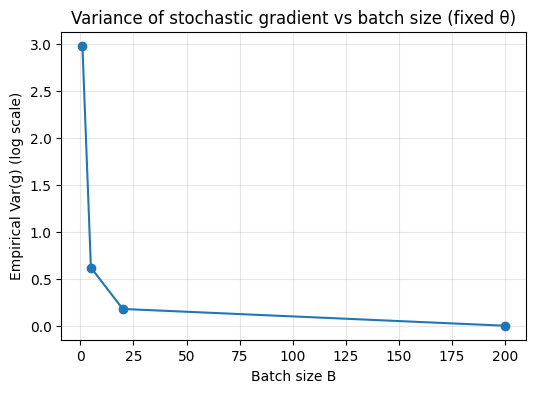

In [ ]:
b_arr = np.array(batch_sizes)
var_arr = np.array([vars_batch[b] for b in batch_sizes])

plt.figure(figsize=(6,4))
plt.plot(b_arr, var_arr, "o-")
plt.xlabel("Batch size B")
plt.ylabel(r"Empirical Var(g) (log scale)")
plt.grid(alpha=0.3, which="both")
plt.title("Variance of stochastic gradient vs batch size (fixed θ)")
plt.show()


5. Comment:
   - Why the variance decreases with larger batches,
   - Why SGD becomes more stable as $N_{\text{batch}}$ increases,
   - The trade-off between stability and computational cost.


## Exercise 3: SGD in 2D

We now study SGD on the 2D non-convex function:

$$
\mathcal{L}(\Theta_1,\Theta_2) = (\Theta_1^2 - 1)^2 + 10(\Theta_2 - \Theta_1^2)^2.
$$

This function has:
- two valleys,
- multiple stationary points,
- strong curvature differences.

1. Treat $\Theta = (\Theta_1,\Theta_2)$ as a “parameter vector” updated by SGD:
   
   $$
   \Theta_{k+1} = \Theta_k - \eta\, g_k,
   $$

   where the ``gradient batch'' $g_k$ is simulated by adding noise to the gradient:
   
   $$
   g_k = \nabla \mathcal{L}(\Theta_k) + \varepsilon_k, \qquad \varepsilon_k \sim \mathcal{N}(0, \sigma^2I),
   $$

   where $\sigma^2$ is called **noise level** and represent the variance of the noise. Try different values of $\sigma^2$ to answer the following questions. *Note: $\sigma^2$ should always be lower than 1*. 


In [124]:
def l(theta):
    return (theta[0]**2 - 1)**2 + 10*(theta[1] - theta[0]**2)**2

def grad_l(theta):
    theta1, theta2 = theta

    dtheta1 = (
        4 * theta1 * (theta1**2 - 1)
        - 40 * theta1 * (theta2 - theta1**2)
    )

    dtheta2 = 20 * (theta2 - theta1**2)

    return np.array([dtheta1, dtheta2])

def SGD_noisy(grad_l, theta0, lr=1e-2, sigma2 = 0.001, n_steps = 5000, seed=0):
    rng = np.random.default_rng(seed)

    theta = theta0.copy()
    theta_hist = [theta0.copy()]

    for k in range(n_steps):
        grad = grad_l(theta)
        noise = rng.normal(0.0, np.sqrt(sigma2), size = 2)
        gk = grad + noise

        theta = theta - lr*gk
        theta_hist.append(theta.copy())
    
    return np.array(theta_hist)

sigma2_vals = [0.0, 0.01, 0.1]
theta0 = np.array([-1.2, 1.6])
lrs = [1e-4, 3e-4, 1e-3]
T = 1000
results = {}

for lr in lrs:
    for sigma2 in sigma2_vals:
        results[(lr, sigma2)] = SGD_noisy(
            grad_l, theta0, lr=lr, sigma2=sigma2, n_steps=5000, seed=42
        )

2. Plot:
   - level sets of $\mathcal{L}(\Theta_1,\Theta_2)$,
   - trajectories of SGD for different noise levels and step sizes.


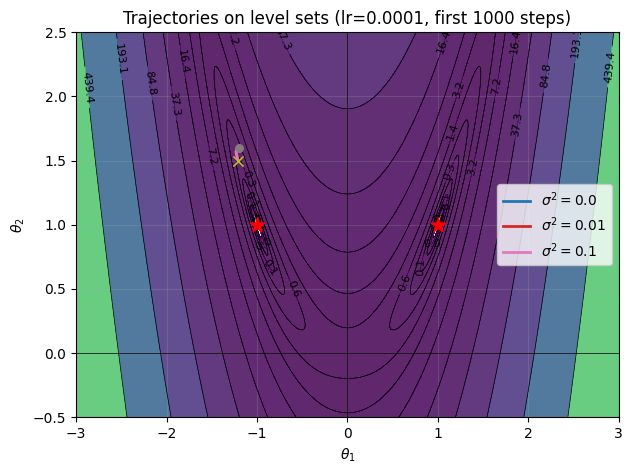

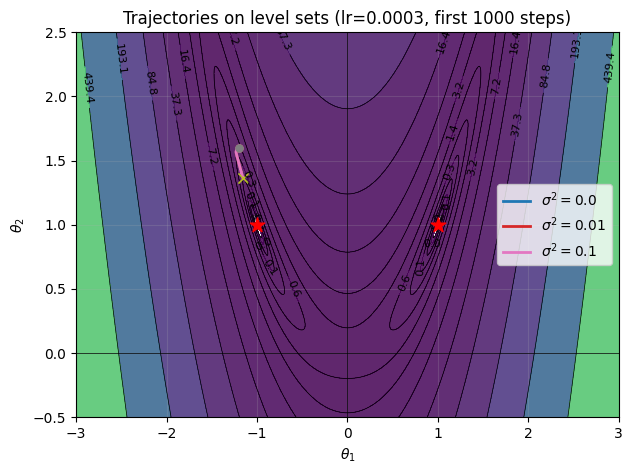

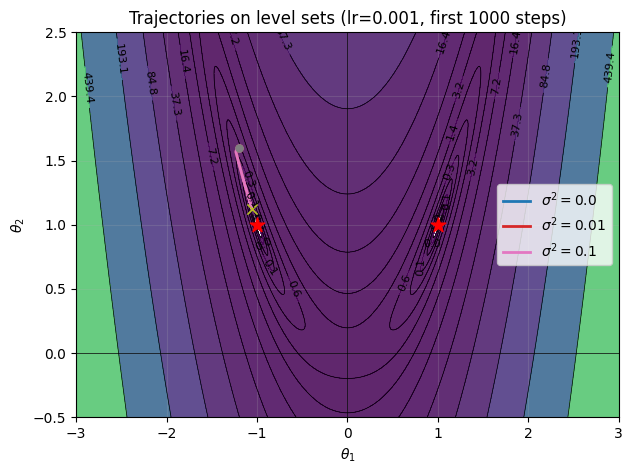

In [130]:
def quad_levelsets(xlim=(-3.0, 3.0), ylim=(-1.0, 4.0), ngrid=400, levels = None, title=None):
    xs = np.linspace(xlim[0], xlim[1], ngrid)
    ys = np.linspace(ylim[0], ylim[1], ngrid)
    X, Y = np.meshgrid(xs, ys)
    Z = (X**2 - 1)**2 + 10 * (Y - X**2)**2

    
    plt.contourf(X, Y, Z, levels=levels, cmap="viridis", alpha=0.85)
    cs = plt.contour(X, Y, Z, levels=levels, colors="black", linewidths=0.5)

    plt.clabel(cs, inline=True, fontsize=8)
    plt.axhline(0, lw=0.5, color="k")
    plt.axvline(0, lw=0.5, color="k")

    if title:
        plt.title(title)

    plt.xlabel(r"$\theta_1$")
    plt.ylabel(r"$\theta_2$")
    plt.grid(alpha=0.2)
levels = np.logspace(-2, 3, 15)

for lr in lrs:
    plt.figure(figsize=(7,5))

    quad_levelsets(
        xlim=(-3, 3),
        ylim=(-0.5, 2.5),
        ngrid=500,
        levels=levels,
        title=fr"Trajectories on level sets (lr={lr}, first {T} steps)"
    )

    for sigma2 in sigma2_vals:
        th = results[(lr, sigma2)][:T]  
        plt.plot(th[:,0], th[:,1], lw=2, label=fr"$\sigma^2={sigma2}$")
        plt.plot(th[0,0], th[0,1], "o", ms=5)     
        plt.plot(th[-1,0], th[-1,1], "x", ms=7)   

    plt.scatter([1, -1], [1, 1], marker="*", s=120, color="red", zorder=5)

    plt.legend()
    plt.show()


3. Discuss:
   - How noise helps escape shallow minima or bad regions,
   - How too much noise prevents convergence,
